## 损失函数

统计学家们就像小贩一样，他们考虑的不是自己获得了多少，而是自己损失了多少。因为如果仅仅从概率，精确度等方面来考虑决策的方式是很不明智的。例如，气象学家在预测飓风袭击某个城市的可能性时，假设他有 95% 的信心认为，飓风不会来的概率介于 99% 和 100% 之间。然后，他对他的预测非常满意，于是建议没有必要进行城市大疏散。但是，不幸的是，飓风确实来了，城市被淹没，整个城市的财产损失不计其数。这个例子就很好的表明了，纯粹依靠精确性度量是具有缺陷的。这也是为什么统计学家非常在意自己预测模型的损失的原因。


- 损失函数
- 期望损失
- 展品出价竞猜
- 金融股票预测
- 最小化损失的求解


### 期望损失

到目前为止，其实我们一直都在基于一个不太现实的假设。那就是，参数的真正值已知。也就说，只有知道真实值和估计值时，我们才能获得损失的具体值。但是，既然已经知道了这个参数的真实值，那么我们再费心费力的寻找最佳估计干什么呢？其实我们是不知道真实值的，而仅仅是找到了它的可能实现。

在贝叶斯推断中，我们认为未知参数是一个有先验分布和后验分布的实际变量。我们只需要从后验分布中抽取一个值用以表示对真实值的可能实现即可。这样，我们就可以计算与估计相关的损失了。但是当我们有了未知参数的整个后验分布，其实更让我们感兴趣的是整个估计的期望损失。因为，期望损失相比于从整个后验分布中取出一个样本作为损失来说，更加合理。

$$ l(\hat{\theta} ) = E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

设来自于后验分布的 $N$ 个样本 $\theta_i,i=1,...,N$，给定损失函数 L，则我们可以使用**大数定理**近似计算出估计值 $\hat{\theta} $ 的期望损失：

$$\frac{1}{N} \sum_{i=1}^N \;L(\theta_i, \hat{\theta} ) \approx E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right]  = l(\hat{\theta} ) $$

期望损失可以用到更多的分布函数，并且考虑到错误的对应结果会带来的损失，可以很好的帮助决策。接下来，让我们用一个实例对其进行说明。

### 实例：“价格竞猜”中的出价优化

1. 比赛双方争夺竞猜展台商品的价格。
2. 每位参赛者都能看到独一无二的一套奖品。
3. 观看后，每位参赛者需要给出自己所看到的整套奖品的投标价格总和。
4. 如果投标价格超过实际价格，投标者将会被取消获奖资格。
5. 如果投标价格低于真正的价格，且差距在 $250 以内，则投标者获得两套（我方的和对方的）奖品。


游戏的难度在与平衡价格的不确定性。我们需要出的价格不能太低，也不能过高。

假设，我们记录了之前的 “价格竞猜” 比赛，获得了这些真实价格的先验分布。为了简单起见，这里我们就假设这些奖品的真实价格服从正态分布随机产生，即：

$$\text{真实价格} \sim \text{Normal}(\mu_p, \sigma_p )$$
其中， $\mu_p = 35 000$ ， $\sigma_p = 7500$.

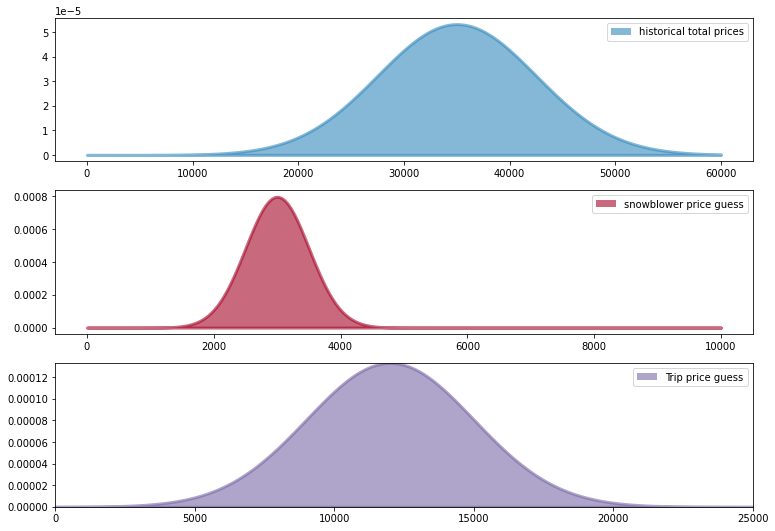

In [1]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                       color="#348ABD", lw=3, alpha=0.6,
                       label="historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                       color="#A60628", lw=3, alpha=0.6,
                       label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                       color="#7A68A6", lw=3, alpha=0.6,
                       label="Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])

当然，当我们看到商品使，其实我们对这些奖品的真实价格就有一些猜测，但却也有一定的不确定性。我们可以使用正态分布来表示这种不确定性，即：


$$ \text{Prize}_i \sim \text{Normal}(\mu_i, \sigma_i ),\;\; i=1,2$$


In [2]:
import pymc3 as pm

# 对两种商品的猜测分布
data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]
# 历史分布
mu_prior = 35e3
std_prior = 75e2
with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)

    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])

    price_estimate = prize_1 + prize_2

    # pm.Normal.dist(mu=price_estimate, sd=(3e3))：对price_estimate再取了一次正态分布，得到总价格的估计
    # 通过对数损失函数来计算估计与真实的误差
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)

    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]
# 获得
price_trace = burned_trace["true_price"]

/Users/hui/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/hui/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/Users/hui/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [second_prize]
>Metropolis: [first_prize]
>Metropolis: [true_price]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 54 seconds.
The number of effective samples is smaller than 10% for some parameters.


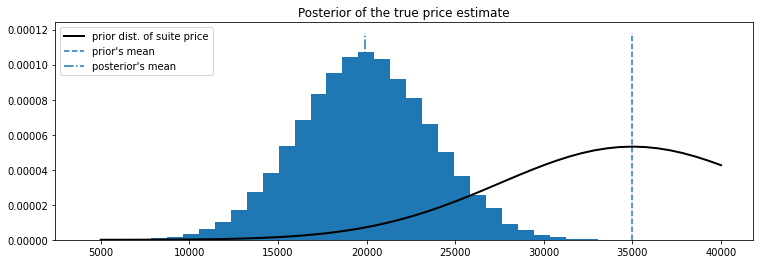

In [4]:
import scipy.stats as stats
figsize(12.5, 4)


x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2,
         label="prior dist. of suite price")

_hist = plt.hist(price_trace, bins=35, density=True, histtype="stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="prior's mean",
           linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]),
           label="posterior's mean", linestyles="-.")
plt.legend(loc="upper left")

In [5]:
# 批量计算损失
def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(guess - true_price[~ix])
    close_mask = [abs(true_price - guess) <= 250]
    loss[close_mask] = -2*true_price[close_mask]
    loss[ix] = risk
    return loss

/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)

(5000.0, 30000.0)

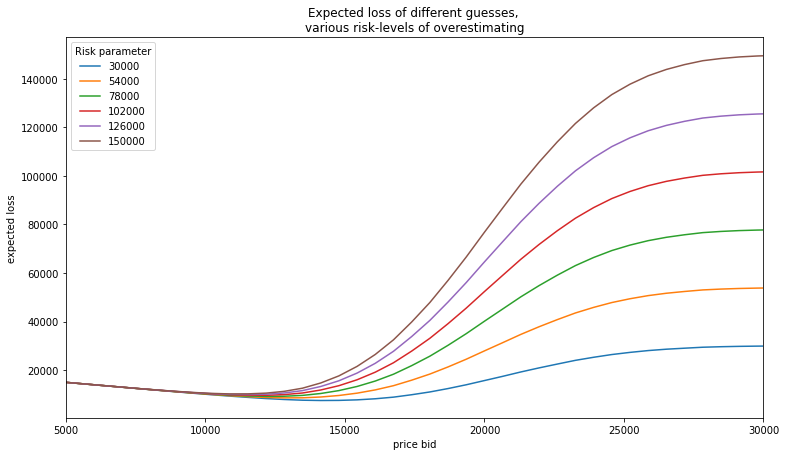

In [6]:
# 假设猜测的
figsize(12.5, 7)
guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)

# 定义计算损失的函数


def expected_loss(guess, risk): return showdown_loss(
    guess, price_trace, risk).mean()


# 设置里这么多个风险系数，计算了不同风险系数下的损害函数
for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)

plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000)

/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


minimum at risk 30000: 14312.94
minimum at risk 54000: 13127.98


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


minimum at risk 78000: 12278.07


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


minimum at risk 102000: 11957.73
minimum at risk 126000: 11711.16


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


minimum at risk 150000: 11288.16


(-1000.0, 80000.0)

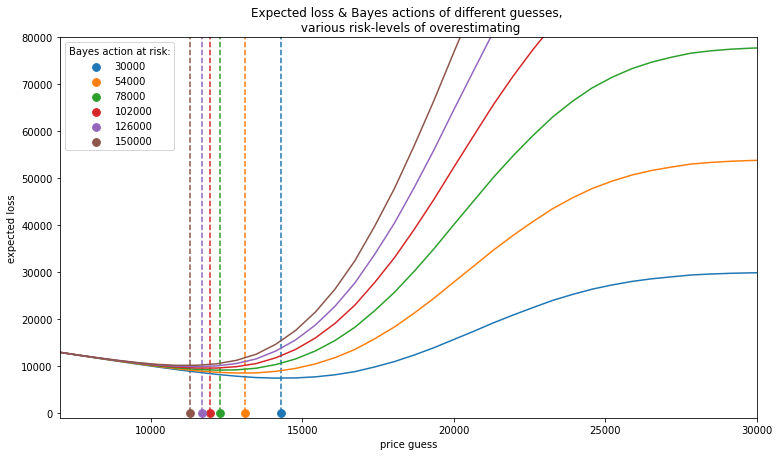

In [7]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,), disp=False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s=60,
                color=_color['color'], label="%d" % _p)
    plt.vlines(_min_results, 0, 120000, color=_color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))

plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000)

从上图中可以看到，如果风险阈值降低，我们就应该提高我们的出价，使其更能接近真实价格。

当然，你可能会说，我们不用 fmin 函数，也可以从上上个图像中看出这个规律。但是，请注意，在高维空间中，我们是无法用肉眼找到极值的。这个时候，我们就不得不使用 fmin 函数。

当然，有些损失函数的贝叶斯行动是可以用公式表示的。比如，均方差损失。该损失的贝叶斯行动就是后验分布的均值，因此，计算均方差损失的贝叶斯行动是非常快的。这也就是为什么均方差损失函数是贝叶斯推断中最常用的函数。当然，所有的损失都必须根据问题的具体情况进行设定，才是最有效的，例如下面的金融预测的例子。

### 实例：金融预测

假设现在有一只股票，它在明天的真实回报率为 0.01 。我们建立了一个模型来预测这只股票的未来的价格。而我们将会直接依赖于预测价格对“是否卖出这只股票”进行决策。我们可以通过计算损失，来决定是否卖出这只股票。那么如何定义损失函数呢？让我先来试试平方差损失函数。

$$ (0.01 - (-0.01))^2 = (0.01 - 0.03)^2 = 0.004$$


In [8]:
def stock_loss(true_return, yhat, alpha=100.):
    if true_return * yhat < 0:
        # 符号相反的情况
        return alpha*yhat**2 - np.sign(true_return)*yhat \
            + abs(true_return)
    else:
        return abs(true_return - yhat)


# 传入参数分别为：真实回报，预测回报，风险系数
stock_loss(true_return=0.1, yhat=0.3, alpha=100), stock_loss(
    true_return=0.1, yhat=-0.1, alpha=100)

(0.19999999999999998, 1.2000000000000004)

Text(0.5, 1.0, 'Stock returns loss if true value = 0.05, -0.02')

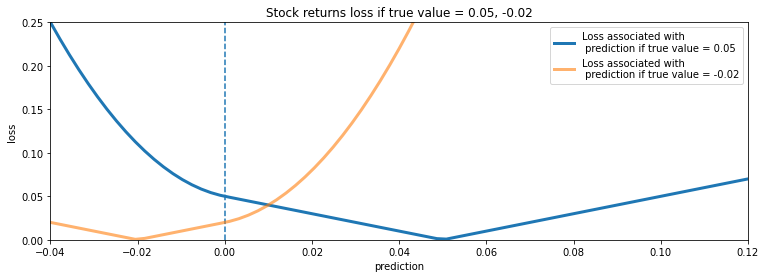

In [9]:
figsize(12.5, 4)

# 设置第一个真实回报为0.05
true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred],
         label="Loss associated with\n prediction if true value = 0.05", lw=3)
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

# 设置第二个真实回报为-0.02
true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha=0.6,
         label="Loss associated with\n prediction if true value = -0.02", lw=3)
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02")

#### 股票数据的模拟

股票的预测最终的目的是希望产生效益。我们通过模型预测出了明天的交易信号（明天的回报预测值）。然后根据这个信号来计算，如果此时卖出股票所能够得到的回报。

因此，我们需要交易信号和真实回报的历史数据。为了简单起见，这里我们自己来模拟这些数据，如下：

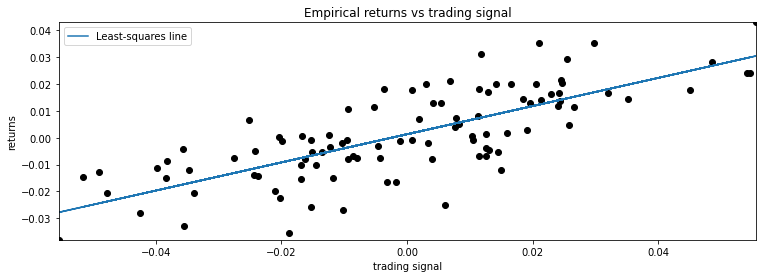

In [10]:
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N)

# 画出模拟数据的最小二乘线
ls_coef_ = np.cov(X, Y)[0, 1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label="Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left")

In [11]:
import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)

    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)

    mean = pm.Deterministic("mean", alpha + beta*X)

    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)

    trace = pm.sample(10000, step=pm.Metropolis())
    burned_trace = trace[2000:]

/Users/hui/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [std]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
def stock_loss(price, pred, coef=500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

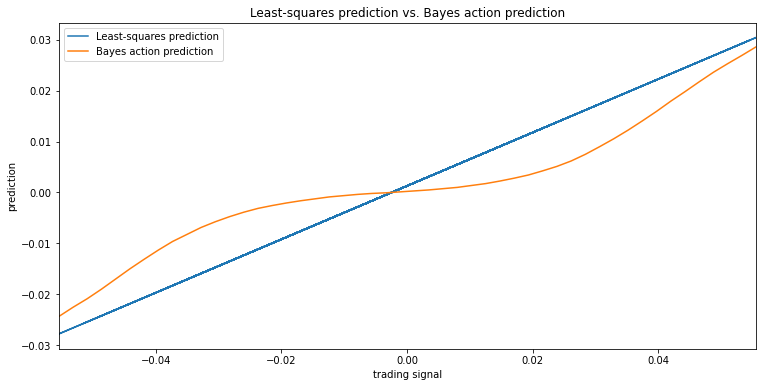

In [13]:
from scipy.optimize import fmin
figsize(12.5, 6)

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N)


def possible_outcomes(signal): return alpha_samples + \
    beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    def tomin(pred): return stock_loss(_possible_outcomes, pred).mean()
    # 得到最佳预测
    opt_predictions[i] = fmin(tomin, 0, disp=False)


plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left")

可以看出，针对于贝叶斯回归线，在交易信号仅仅为 0 时，回报也都趋近于 0 （也就是较为平缓）。这是因为，我们预测的值为 -0.001 时，我们的预测值其实和正方向的值相差不大，我们没有多大信心去说此时应该卖掉股票还是不买，因此损失也趋近于 0 。而当我们的预测为 - 0.04，这种回收率就会正方向相差很大，我们就可以很自信的确定明天肯定是降（因为即时有 0.02 的预测误差，我们的预测值加上 0.02 也是负的）。这个特性，有个名字叫做**稀疏预测**（即离 0 越远，损失越大，越对自己预测出来的正负值有自信）。这也就是为什么，在此情况下，贝叶斯回归线比最小二乘更优的原因。

稀疏预测模型（即贝叶斯回归模型）不是千方百计的去拟合数据，它做的其实是利用我们定义的股票损失来寻找最低损失，为我们做出最佳决策。而最小二乘法只是机械地去找到平方误差下的最佳拟合。